# Nichesphere tutorial (PIC-seq)

Nichesphere is an sc-verse [ref] compatible Python library which allows the user to find differentially colocalised cellular niches based on cell type pairs colocalisation probabilities in different conditions. Cell type pair colocalisation probabilities are obtained from deconvoluted spatial transcriptomics / PIC-seq data (probabilities of finding each cell type in each spot / multiplet).

It also offers the possibility to look at localised differential cell - cell communication based on Ligand-Receptor pairs expression data, such as results from CrossTalkeR [ref].


## Libraries and functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import networkx as nx
import warnings
import scanpy as sc
import leidenalg
import igraph as ig
import sklearn
import itertools

warnings.filterwarnings("ignore")

## My package test
import nichesphere.tl

## PIC-seq data at first glance

Cell type proportions in doublets

In [2]:
CTprops=pd.read_csv('../../../nichesphere_tutorial_data/PICseq_doublets_newCTnames_CTprops_BP_annotation_noMSCs_Xist.csv', index_col=0)
CTprops

,DC,InfiltMac,Fibro,MonoPro,Neut2,Ly6ClowMac,Baso,TCells,Neut1,MK,ResMac,OsteoCAR,EC,Ery,OsteoMac,BCells
IS3_AAACCCAAGAGTCAGC-1,0.022321,0.009692,0.002134,0.019810,0.027176,0.005223,0.005350,0.006909,0.859264,0.013108,0.004198,0.002142,0.004581,0.008093,0.008558,0.001440
IS3_AAACCCAAGGGCTGAT-1,0.009302,0.013937,0.003087,0.008581,0.013993,0.868811,0.012865,0.014621,0.009612,0.008361,0.005726,0.003589,0.009012,0.008289,0.008231,0.001982
IS3_AAACCCACACGCCAGT-1,0.675809,0.260256,0.001310,0.006162,0.004601,0.005598,0.004135,0.005520,0.009202,0.010234,0.002177,0.001419,0.002356,0.006113,0.004108,0.001000
IS3_AAACCCACACTACCGG-1,0.002942,0.003383,0.001131,0.850736,0.101740,0.002235,0.004787,0.002345,0.007967,0.005849,0.001834,0.001331,0.002962,0.003802,0.006055,0.000903
IS3_AAACCCACAGATCCTA-1,0.030429,0.079342,0.005465,0.013012,0.047528,0.643361,0.025168,0.012989,0.035907,0.018483,0.043229,0.005768,0.010787,0.014002,0.010533,0.003997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IS4_TTTGTTGTCATTTCCA-1,0.015058,0.009397,0.005797,0.214404,0.325302,0.012085,0.010666,0.021210,0.197670,0.032304,0.008685,0.008545,0.010694,0.111081,0.011940,0.005164
IS4_TTTGTTGTCCACTGGG-1,0.026123,0.044457,0.014409,0.023916,0.026968,0.041007,0.016348,0.027398,0.021926,0.017803,0.558519,0.021060,0.046810,0.017795,0.037089,0.058372
IS4_TTTGTTGTCCTCTCTT-1,0.456742,0.017559,0.016114,0.158077,0.026194,0.010831,0.010448,0.032528,0.069581,0.043775,0.018302,0.009012,0.022190,0.088792,0.015852,0.004001
IS4_TTTGTTGTCCTTATGT-1,0.185427,0.043160,0.022633,0.298970,0.029145,0.031779,0.012350,0.028351,0.030965,0.093895,0.011551,0.025358,0.026439,0.138098,0.017492,0.004385


Gene expression data

In [3]:
adata_singlets=sc.read('../../../nichesphere_tutorial_data/PICseq_singlets_noSkMusCells_newNames.h5ad')
adata_doublets=sc.read('../../../nichesphere_tutorial_data/PICseq_doublets.h5ad')

## Colocalisation

We will compute colocalisation probabilities from deconvolution results (cell type probabilities per spot) with the function getColocProbs to get cell type pairs colocalisation probabilities

Here we will get concatenated single colocalisation sample matrices of cell type x cell type.

In [4]:
#### trial new function
CTcolocalizationP= nichesphere.tl.getColocProbs(CTprobs=CTprops, spotSamples=adata_doublets.obs.stage)
CTcolocalizationP

,DC,InfiltMac,Fibro,MonoPro,Neut2,Ly6ClowMac,Baso,TCells,Neut1,MK,ResMac,OsteoCAR,EC,Ery,OsteoMac,BCells,sample
DC,0.043204,0.011930,0.000577,0.007006,0.002704,0.004632,0.001131,0.001506,0.005417,0.004213,0.001673,0.000537,0.000650,0.001424,0.001665,0.000200,TPO
InfiltMac,0.011930,0.090976,0.001273,0.005785,0.005563,0.021474,0.002519,0.003258,0.005380,0.003517,0.004492,0.001227,0.001781,0.002080,0.003197,0.000545,TPO
Fibro,0.000577,0.001273,0.016769,0.000746,0.000636,0.001370,0.000348,0.000389,0.000755,0.000503,0.000454,0.001178,0.000605,0.000291,0.000426,0.000077,TPO
MonoPro,0.007006,0.005785,0.000746,0.067752,0.007023,0.004591,0.002202,0.001787,0.009067,0.007756,0.001404,0.000822,0.000940,0.001665,0.001426,0.000261,TPO
Neut2,0.002704,0.005563,0.000636,0.007023,0.034074,0.005379,0.001408,0.001432,0.012879,0.001878,0.001241,0.000619,0.000780,0.001300,0.001172,0.000269,TPO
Ly6ClowMac,0.004632,0.021474,0.001370,0.004591,0.005379,0.079528,0.002479,0.003234,0.005721,0.003308,0.006094,0.001331,0.001942,0.002117,0.002825,0.000582,TPO
Baso,0.001131,0.002519,0.000348,0.002202,0.001408,0.002479,0.018511,0.000854,0.001788,0.001864,0.000715,0.000350,0.000394,0.000570,0.000527,0.000112,TPO
TCells,0.001506,0.003258,0.000389,0.001787,0.001432,0.003234,0.000854,0.008295,0.001833,0.001311,0.000901,0.000376,0.000404,0.000579,0.000591,0.000134,TPO
Neut1,0.005417,0.005380,0.000755,0.009067,0.012879,0.005721,0.001788,0.001833,0.074294,0.002919,0.001507,0.000815,0.000974,0.002008,0.001398,0.000347,TPO
MK,0.004213,0.003517,0.000503,0.007756,0.001878,0.003308,0.001864,0.001311,0.002919,0.022691,0.001172,0.000490,0.000624,0.001986,0.001447,0.000144,TPO


Same cell type interactions will be excluded later on, so we'll have a list of same cell type interaction pairs in order to subset the colocalisation table we'll generate in the next step.

In [5]:
oneCTints=CTcolocalizationP.columns[range(len(CTcolocalizationP.columns)-1)]+'-'+CTcolocalizationP.columns[range(len(CTcolocalizationP.columns)-1)]

Then we will reshape the colocalisation data into a matrix of cell type pairs x samples

In [6]:
colocPerSample=nichesphere.tl.reshapeColoc(CTcoloc=CTcolocalizationP, complete=1)
colocPerSample

,DC-DC,DC-InfiltMac,DC-Fibro,DC-MonoPro,DC-Neut2,DC-Ly6ClowMac,DC-Baso,DC-TCells,DC-Neut1,DC-MK,...,BCells-Baso,BCells-TCells,BCells-Neut1,BCells-MK,BCells-ResMac,BCells-OsteoCAR,BCells-EC,BCells-Ery,BCells-OsteoMac,BCells-BCells
TPO,0.043204,0.011930,0.000577,0.007006,0.002704,0.004632,0.001131,0.001506,0.005417,0.004213,...,0.000112,0.000134,0.000347,0.000144,0.000150,0.000077,0.000050,0.00007,0.000078,0.000504
EV,0.018899,0.003145,0.002420,0.009168,0.004171,0.001827,0.001256,0.003089,0.006253,0.005446,...,0.000338,0.000741,0.001673,0.001140,0.000657,0.000472,0.000449,0.00168,0.001045,0.004976


Probabilities of all cell type pairs in each sample should sum up to 1:

In [7]:
colocPerSample.sum(axis=1)

TPO    1.0
EV     1.0
dtype: float64

In this case, we do not have multiple samples from our two different conditions, so we will compute the expected probability of each cell type pair to occur by multiplying cell type proportions from the single cell data:

In [8]:
scCTpairsProbs_TPO=nichesphere.tl.getExpectedColocProbsFromSCs(sc_adata=adata_singlets, sample='TPO', cell_types=CTprops.columns, sc_data_sampleCol='stage', sc_adata_annotationCol='annotation')
scCTpairsProbs_EV=nichesphere.tl.getExpectedColocProbsFromSCs(sc_adata=adata_singlets, sample='EV', cell_types=CTprops.columns, sc_data_sampleCol='stage', sc_adata_annotationCol='annotation')


Which we will use to test for differential co-localization

Differential colocalisation analysis

Here we will test differential colocalisation by generating a distribution of O/E ratios for colocalisation probabilities of cell type pairs in randomly generated doublets (from our singlets data)

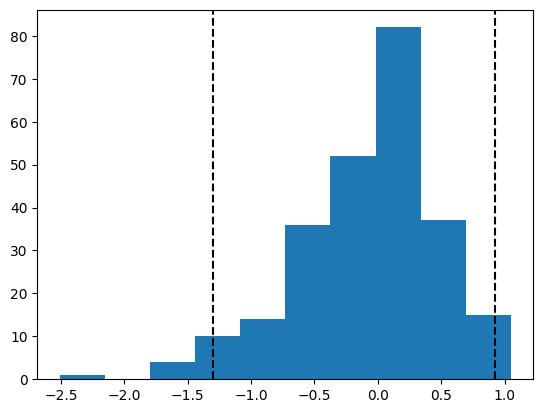

In [10]:
test=nichesphere.tl.PIC_BGdoubletsOEratios(adata_singlets=adata_singlets)
plt.hist(np.log2(test), bins=10)
plt.axvline(np.quantile(np.log2(test), 0.025), color='k', linestyle='dashed')
plt.axvline(np.quantile(np.log2(test), 0.975), color='k', linestyle='dashed')
plt.savefig('../../../figures_nichesphere_tutorial/randomDoubletsOEratiosDist.pdf')
plt.show()

Differential colocalisation will be then significant if the value obtained is among the 0.025 smallest or biggest values in the distribution.
So we will calculate observed / expected ratios, log2 scale them and filter non significant values with the function OvsE_coloc_test.

Then we will plot significant values in a heatmap

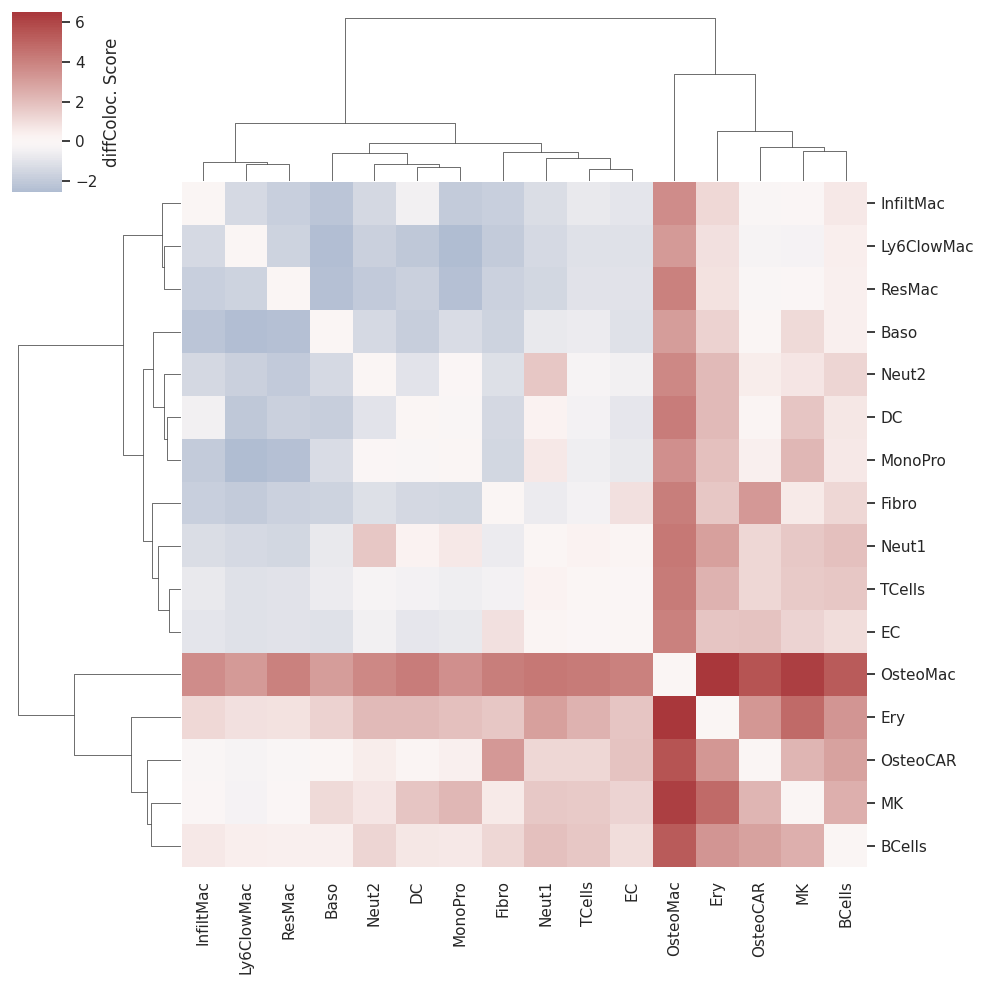

In [11]:
#Unfiltered (To get dendrogram clusters)
OvsE_TPO_HMdf=nichesphere.tl.OvsE_coloc_test(observedColocProbs=colocPerSample.loc['TPO'], expectedColocProbs=scCTpairsProbs_TPO['count'], cell_types=CTprops.columns, 
                              testDistribution=test, oneCTinteractions=oneCTints, p=1)
## Plot heatmap
sns.set(font_scale=1)
plot=sns.clustermap(OvsE_TPO_HMdf, cmap='vlag', center=0, method='ward', cbar_kws={'label': 'diffColoc. Score'})

Based on the clustering in the heatmap, we defined 4 clusters; '1_Macrophages', '2_Innate_Immune', '3_Neutrophil_Fibroblast', '4_Fibrosis_Core'

In [12]:
#### Clusters from clustermap on scores matrix
heatClusts=scipy.cluster.hierarchy.fcluster(plot.dendrogram_col.linkage, 1.5, depth=4)
pd.Series(heatClusts, index=plot.dendrogram_col.data.columns)

DC            2
InfiltMac     1
Fibro         3
MonoPro       2
Neut2         2
Ly6ClowMac    1
Baso          2
TCells        3
Neut1         3
MK            4
ResMac        1
OsteoCAR      4
EC            3
Ery           4
OsteoMac      4
BCells        4
dtype: int32

In [13]:
#Niches colors
cmap = plt.cm.get_cmap('tab10', 10)
clist=[mcolors.rgb2hex(cmap(i)[:3]) for i in [9]]
cmap = plt.cm.get_cmap('Set1', 9)
#clist=clist+[mcolors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
clist=clist+[mcolors.rgb2hex(cmap(i)[:3]) for i in [7,2,3]]
niche_cols=pd.Series(clist, index=['1_Macrophages', '2_Innate_Immune', '3_Neutrophil_Fibroblast', '4_Fibrosis_Core'])
niche_cols

1_Macrophages              #17becf
2_Innate_Immune            #f781bf
3_Neutrophil_Fibroblast    #4daf4a
4_Fibrosis_Core            #984ea3
dtype: object

In [14]:
niches_dict={'1_Macrophages':['InfiltMac', 'Ly6ClowMac', 'ResMac'],
     '2_Innate_Immune':['DC', 'MonoPro', 'Neut2', 'Baso'],
     '3_Neutrophil_Fibroblast':['Fibro', 'TCells', 'Neut1', 'EC'],
     '4_Fibrosis_Core':['MK', 'OsteoCAR', 'Ery', 'OsteoMac', 'BCells']}
niches_dict

{'1_Macrophages': ['InfiltMac', 'Ly6ClowMac', 'ResMac'],
 '2_Innate_Immune': ['DC', 'MonoPro', 'Neut2', 'Baso'],
 '3_Neutrophil_Fibroblast': ['Fibro', 'TCells', 'Neut1', 'EC'],
 '4_Fibrosis_Core': ['MK', 'OsteoCAR', 'Ery', 'OsteoMac', 'BCells']}

In [15]:
niches_df=nichesphere.tl.cells_niche_colors(CTs=CTprops.columns, niche_colors=niche_cols, niche_dict=niches_dict)
niches_df

,cell,niche,color
cell,,,
DC,DC,2_Innate_Immune,#f781bf
InfiltMac,InfiltMac,1_Macrophages,#17becf
Fibro,Fibro,3_Neutrophil_Fibroblast,#4daf4a
MonoPro,MonoPro,2_Innate_Immune,#f781bf
Neut2,Neut2,2_Innate_Immune,#f781bf
Ly6ClowMac,Ly6ClowMac,1_Macrophages,#17becf
Baso,Baso,2_Innate_Immune,#f781bf
TCells,TCells,3_Neutrophil_Fibroblast,#4daf4a
Neut1,Neut1,3_Neutrophil_Fibroblast,#4daf4a


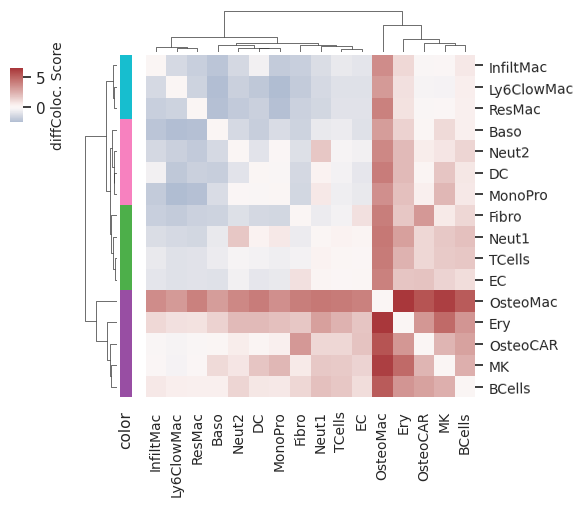

In [16]:
## Plot improved heatmap
sns.set(font_scale=1)
plot=sns.clustermap(OvsE_TPO_HMdf, cmap='vlag', center=0, method='ward', cbar_kws={'label': 'diffColoc. Score'}, row_colors=niches_df.color)

hm = plot.ax_heatmap.get_position()
plt.setp(plot.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10)
plt.setp(plot.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10)

## heatmap position
plot.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*0.5, hm.height*0.5])
col = plot.ax_col_dendrogram.get_position()
## dendrograms position
plot.ax_col_dendrogram.set_position([col.x0, col.y0*0.58, col.width*0.5, col.height*0.25])
row = plot.ax_row_dendrogram.get_position()
plot.ax_row_dendrogram.set_position([row.x0*8.5, row.y0, row.width*0.2, row.height*0.5])
## colorbar position
x0, y0, w, h = plot.cbar_pos
plot.ax_cbar.set_position([x0*4, y0*0.5, w*0.25, h*0.3])
plot.figure.axes[-1].yaxis.label.set_size(10)

## row_colors position
box = plot.ax_row_colors.get_position()
plot.ax_row_colors.set_position([box.x0, box.y0, box.width*0.5, box.height*0.5])
#plot.ax_cbar.tick_params(labelsize=20)
#plot.tick_params(labelsize=10)
#plot.cbar_kws(labelsize=10)

plt.setp(plot.ax_heatmap.yaxis.get_majorticklabels(), rotation=1)
plt.savefig('../../../figures_nichesphere_tutorial/OvsE_TPO_clustered.pdf')
plt.show()

The we'll filter non-significant scores

In [17]:
## Filter non significant scores
OvsE_TPO_HMdf=nichesphere.tl.OvsE_coloc_test(observedColocProbs=colocPerSample.loc['TPO'], expectedColocProbs=scCTpairsProbs_TPO['count'], cell_types=CTprops.columns, 
                              testDistribution=test, oneCTinteractions=oneCTints)


Colocalisation network

To build the colocalisation network, we will get an adjacency matrix (adj) based on the cosine similarities of the distributions of differential colocalisation scores for the different cell types

In [18]:
##Cosine similarity plus pseudocount
adj=pd.DataFrame(sklearn.metrics.pairwise.cosine_similarity(OvsE_TPO_HMdf)+1)
adj.index=OvsE_TPO_HMdf.index
adj.columns=OvsE_TPO_HMdf.columns

##Cell pairs with not significant differential colocalisation get 0
adj[OvsE_TPO_HMdf==0]=0
adj[adj==1]=0

Then the network is built just taking into account the differentially colocalised cell type pairs. The cell groups dictionary can be used here to visualize different cell groups in different colors.

To find niches of differentially colocalised cell types, we can cluster the adjacency matrix / test matrix using hierarchical clustering as shown above.

Now we can color the nodes in the network by niche

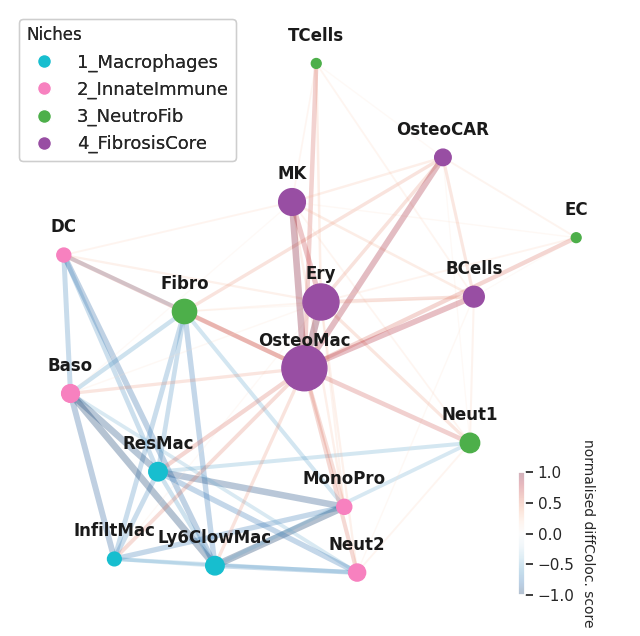

In [19]:
### With adj dendrogram clusters
plt.rcParams['axes.facecolor'] = "None"
gCol=nichesphere.tl.colocNW(x_diff=OvsE_TPO_HMdf, adj=adj,cell_group=niches_dict, clist=clist, BTsizedNodes=True)

weights=nx.get_edge_attributes(gCol,'weight').values()
d=pd.Series(np.abs(pd.Series(list(weights))))

d[[i<0 for i in list(weights)]]=d[[i<0 for i in list(weights)]]/np.max(d[[i<0 for i in list(weights)]])
d[[i>0 for i in list(weights)]]=d[[i>0 for i in list(weights)]]/np.max(d[[i>0 for i in list(weights)]])

legend_elements1 = [plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.tab10.colors[9], lw=4, label='1_Macrophages', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.Set1.colors[7], lw=4, label='2_InnateImmune', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.Set1.colors[2], lw=4, label='3_NeutroFib', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.Set1.colors[3], lw=4, label='4_FibrosisCore', ms=10)]

plt.gca().add_artist(plt.legend(handles=legend_elements1,loc='upper left', fontsize=13, title='Niches', alignment='left'))
with plt.rc_context({'image.composite_image': False}):
    plt.savefig('../../../figures_nichesphere_tutorial/diffColocNW_TPO_4adjClusts.pdf', format="pdf", bbox_inches="tight")

We can then calculate some network statistics with the networkX package [ref] functions:

In [20]:
t1=pd.DataFrame({'influencer':[nx.eigenvector_centrality(gCol)[x] for x in list(gCol.nodes)], 'betweenness':[nx.betweenness_centrality(gCol)[x] for x in list(gCol.nodes)], 
                 'degree':[nx.degree_centrality(gCol)[x] for x in list(gCol.nodes)], 'pagerank':[nx.pagerank(gCol, weight=None)[x] for x in list(gCol.nodes)]})
t1.index=list(gCol.nodes)

And visualize them

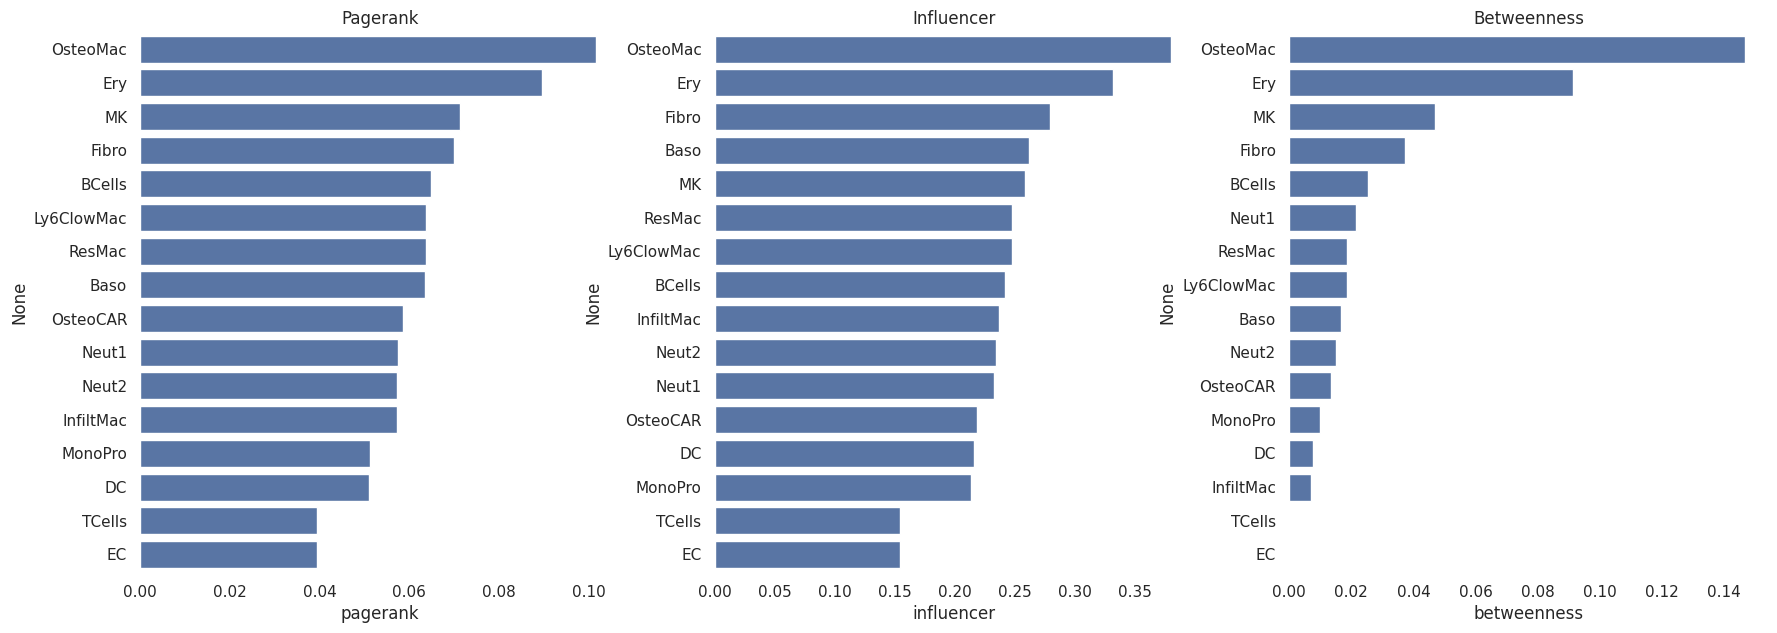

In [21]:

fig, axes = plt.subplots(1, 3, figsize=(21, 7))
sns.barplot(ax=axes[0], y=t1.sort_values('pagerank', ascending=False).index, x='pagerank', data=t1.sort_values('pagerank', ascending=False))
axes[0].set_title('Pagerank')
sns.barplot(ax=axes[1], y=t1.sort_values('influencer', ascending=False).index, x='influencer', data=t1.sort_values('influencer', ascending=False))
axes[1].set_title('Influencer')
sns.barplot(ax=axes[2], y=t1.sort_values('betweenness', ascending=False).index, x='betweenness', data=t1.sort_values('betweenness', ascending=False))
axes[2].set_title('Betweenness')
plt.savefig('../../../figures_nichesphere_tutorial/diffColocNW_stats.pdf')

To filter the communication data, we will make a binary vector indicating whether each cell type pair is differentially colocalised

In [22]:
#############################

Then we can also define different interaction categories depending on the interacting niches

In [23]:
pairCatDFdir=nichesphere.tl.get_pairCatDFdir(niches_dict, CTcolocalizationP, niches_df.niche)
pairCatDFdir

,pairs,colocCats
0,DC->DC,2_Innate_Immune->2_Innate_Immune
1,DC->InfiltMac,2_Innate_Immune->1_Macrophages
2,DC->Fibro,2_Innate_Immune->3_Neutrophil_Fibroblast
3,DC->MonoPro,2_Innate_Immune->2_Innate_Immune
4,DC->Neut2,2_Innate_Immune->2_Innate_Immune
...,...,...
251,BCells->OsteoCAR,4_Fibrosis_Core->4_Fibrosis_Core
252,BCells->EC,4_Fibrosis_Core->3_Neutrophil_Fibroblast
253,BCells->Ery,4_Fibrosis_Core->4_Fibrosis_Core
254,BCells->OsteoMac,4_Fibrosis_Core->4_Fibrosis_Core


In [24]:
## To filter communication data (network)
colocFilt=nichesphere.tl.getColocFilter(pairCatDF=pairCatDFdir, adj=adj, oneCTints=oneCTints.str.replace('-', '->'))
colocFilt

,filter
pairs,
DC->DC,1.0
DC->InfiltMac,0.0
DC->Fibro,1.0
DC->MonoPro,0.0
DC->Neut2,0.0
...,...
BCells->OsteoCAR,1.0
BCells->EC,1.0
BCells->Ery,1.0


## **Communication**

Get cell communication data (CrossTalkeR tables)

In [25]:
crossTalker_ctrlComm=pd.read_csv('../../../nichesphere_tutorial_data/PICseq_crossTalker_noSkMusCells_newNamesEV.csv')
crossTalker_tpoComm=pd.read_csv('../../../nichesphere_tutorial_data/PICseq_crossTalker_noSkMusCells_newNamesTPO.csv')

In [26]:

crossTalker_ctrlComm=nichesphere.tl.processCTKRoutput(crossTalker_ctrlComm)
crossTalker_tpoComm=nichesphere.tl.processCTKRoutput(crossTalker_tpoComm)

Names of cell types need to match between communication and colocalisation data

Load the ligands database. This comes from tables from different ligand databases 
which were concatenated.

In [27]:
allDBs=pd.read_csv('../../../nichesphere_tutorial_data/allDBs.csv', index_col=0)
allDBs['Ligand']=allDBs['Ligand'].str.lower()
allDBs

,Ligand,category,db,ensembl_gene_id,iname,synonyms,description
2,col1a1,Collagens,matrissome,NaN,NaN,NaN,NaN
5,col1a2,Collagens,matrissome,NaN,NaN,NaN,NaN
17,col6a3,Collagens,matrissome,NaN,NaN,NaN,NaN
23,col3a1,Collagens,matrissome,NaN,NaN,NaN,NaN
30,col2a1,Collagens,matrissome,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
125,pmaip1,apoptosis,deathbase,ENSDARG00000071431,Zebrafish,phorbol-12-myristate-13-acetate-induced protei...,phorbol-12-myristate-13-acetate-induced protei...
126,tnfrsfa,apoptosis,deathbase,ENSDARG00000004451,Zebrafish,tumor necrosis factor receptor superfamily mem...,"tumor necrosis factor receptor superfamily, me..."
127,tnfsf10l,apoptosis,deathbase,ENSDARG00000004196,Zebrafish,tumor necrosis factor (ligand) superfamily mem...,"tumor necrosis factor (ligand) superfamily, me..."
128,tnfsf10l2,apoptosis,deathbase,ENSDARG00000057241,Zebrafish,tumor necrosis factor (ligand) superfamily mem...,"tumor necrosis factor (ligand) superfamily, me..."


Then we'll calculate communication scores summing scores for a specific LR pair for a specific cell type pair and separate these scores per ligand category to know which cell type pairs are interacting through which mechanisms.

In [28]:
EV_CTpairScores_byCat2_dir_colocClusts=nichesphere.tl.lr_ctPairScores_perCat_dir(ccommTable=crossTalker_ctrlComm, db=allDBs, dbCatCol='category', dbMatchCol='Ligand', 
                        ccommMatchCol='gene_A', ccommLRscoresCol='MeanLR', oneCTinteractions=oneCTints.str.replace('-', '@'), condition='EV', pairCatDF=pairCatDFdir)

In [29]:
tpoCTpairScores_byCat2_dir_colocClusts=nichesphere.tl.lr_ctPairScores_perCat_dir(ccommTable=crossTalker_tpoComm, db=allDBs, dbCatCol='category', dbMatchCol='Ligand', 
                        ccommMatchCol='gene_A', ccommLRscoresCol='MeanLR', oneCTinteractions=oneCTints.str.replace('-', '@'), condition='TPO', pairCatDF=pairCatDFdir)

Some interactions might be present only in one condition, so we will assign 0 values to the interactions that do not appear in one condition to be able to compare conditions

In [30]:
EV_CTpairScores_byCat2_dir_colocClusts, tpoCTpairScores_byCat2_dir_colocClusts = nichesphere.tl.equalizeScoresTables(ctrlTbl=EV_CTpairScores_byCat2_dir_colocClusts, 
                                                    expTbl=tpoCTpairScores_byCat2_dir_colocClusts, ctrlCondition='EV', expCondition='TPO')

Filter by colocalisation

In [31]:
EV_CTpairScores_byCat2_dir_colocClusts=EV_CTpairScores_byCat2_dir_colocClusts[[i in colocFilt.index[colocFilt['filter']==1] for i in EV_CTpairScores_byCat2_dir_colocClusts.pairs]]
tpoCTpairScores_byCat2_dir_colocClusts=tpoCTpairScores_byCat2_dir_colocClusts[[i in colocFilt.index[colocFilt['filter']==1] for i in tpoCTpairScores_byCat2_dir_colocClusts.pairs]]

Then we can test for differential cell cell communication across mechanisms and cell groups with the function 'tl.diffCcommStats' and plot the resulting scores as follows:

In [32]:
## Differential communication statistics
EVtpo_diffCcommTable_colocGroups_dir=nichesphere.tl.diffCcommStats(c1CTpairScores_byCat=tpoCTpairScores_byCat2_dir_colocClusts, c2CTpairScores_byCat=EV_CTpairScores_byCat2_dir_colocClusts, cellCatCol='colocCats')


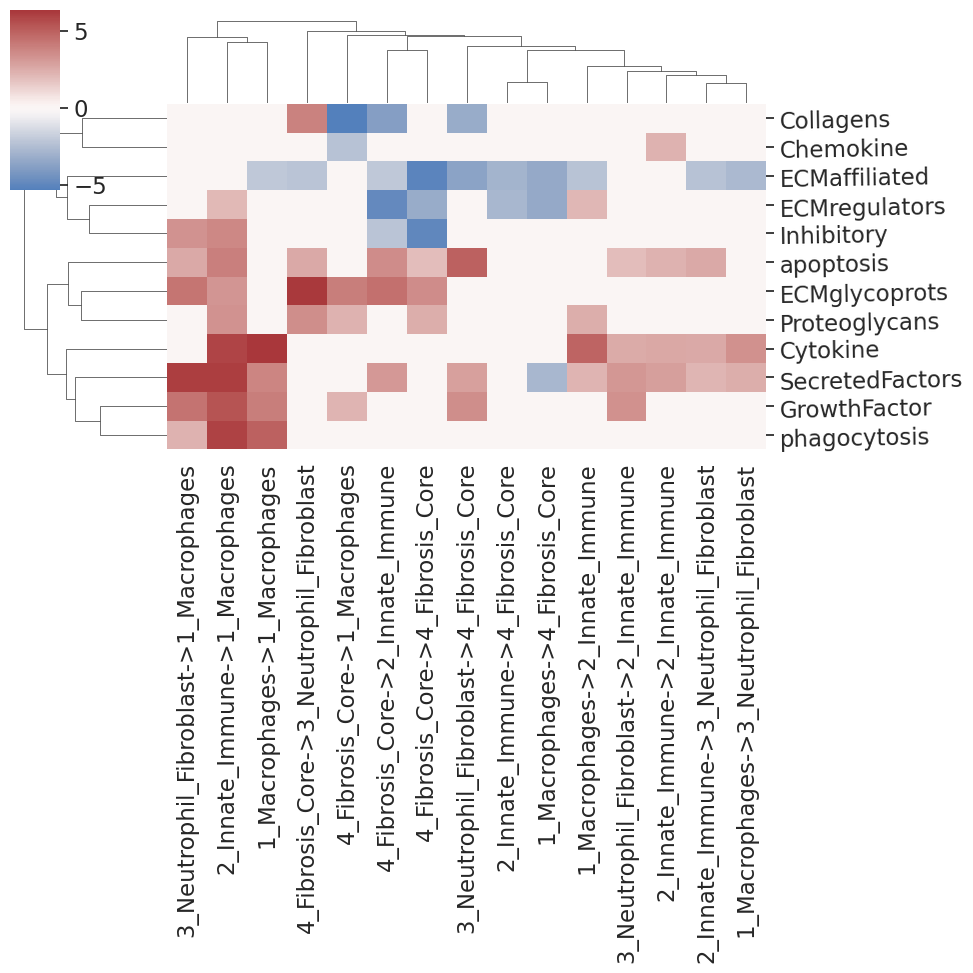

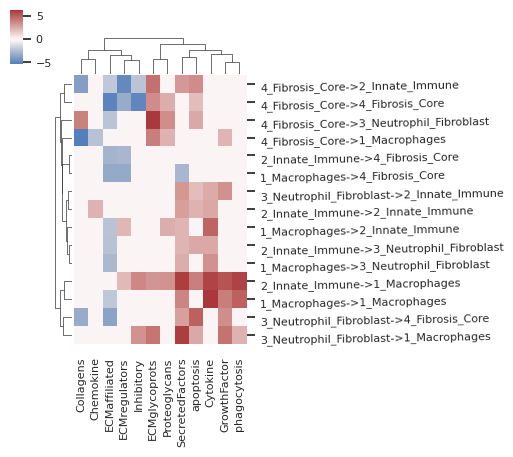

In [33]:
## Differential communication by coloc group

## Plot in heatmap
hm_df, cm=nichesphere.tl.plotDiffCcommStatsHM(diffCommTable=EVtpo_diffCcommTable_colocGroups_dir, min_pval=0.05)

cm=sns.clustermap(hm_df.T, cmap='vlag', center=0, method='complete')
#plot.set_yticklabels(rotation=90)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=1)

hm = cm.ax_heatmap.get_position()
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), fontsize=8)
plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), fontsize=8)

## heatmap position
cm.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*0.5, hm.height*0.45])
col = cm.ax_col_dendrogram.get_position()
## dendrograms position
cm.ax_col_dendrogram.set_position([col.x0, col.y0*0.6, col.width*0.5, col.height*0.25])
row = cm.ax_row_dendrogram.get_position()
cm.ax_row_dendrogram.set_position([row.x0*3.5, row.y0, row.width*0.2, row.height*0.45])
## colorbar position
x0, y0, w, h = cm.cbar_pos
cm.ax_cbar.set_position([x0*2.5, y0*0.63, w*0.25, h*0.3])
cm.tick_params(labelsize=8)


#plt.savefig('./figures/colocFiltereddiffComm_colocClusts_categories_4clusts.pdf')
plt.savefig('../../../figures_nichesphere_tutorial/colocFiltereddiffComm_colocClusts_categories_4clusts_phagocyt_death.pdf')

plt.show()

Next, we can look at differential cell communication per cell type pair in each ligand category

In [34]:
## Differential cell communication per cell type pair

## Differential communication statistics
EVtpo_diffCcommTable2_CTpair_dir=nichesphere.tl.diffCcommStats(c1CTpairScores_byCat=tpoCTpairScores_byCat2_dir_colocClusts, c2CTpairScores_byCat=EV_CTpairScores_byCat2_dir_colocClusts, cellCatCol='pairs')

## Plot in heatmap, get heatmap data
#x_EVtpo_dir=nichesphere.tl.plotDiffCcommStatsHM(diffCommTable=EVtpo_diffCcommTable2_CTpair_dir, min_pval=0.1)

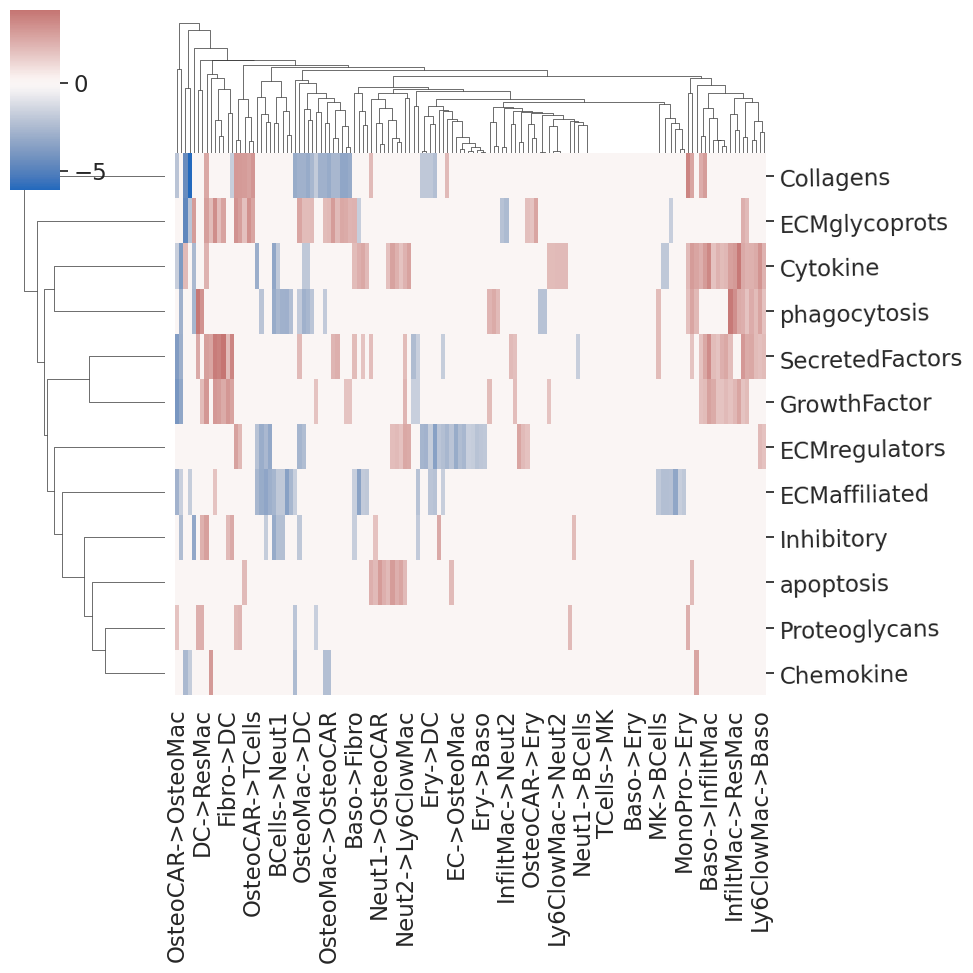

In [35]:
x_EVtpo_dir, plothm=nichesphere.tl.plotDiffCcommStatsHM(diffCommTable=EVtpo_diffCcommTable2_CTpair_dir, min_pval=0.1)

We can also plot Ligand-Receptor based cellular interactions per mechanism on the colocalisation network after filtering the communication data

<Figure size 640x480 with 0 Axes>

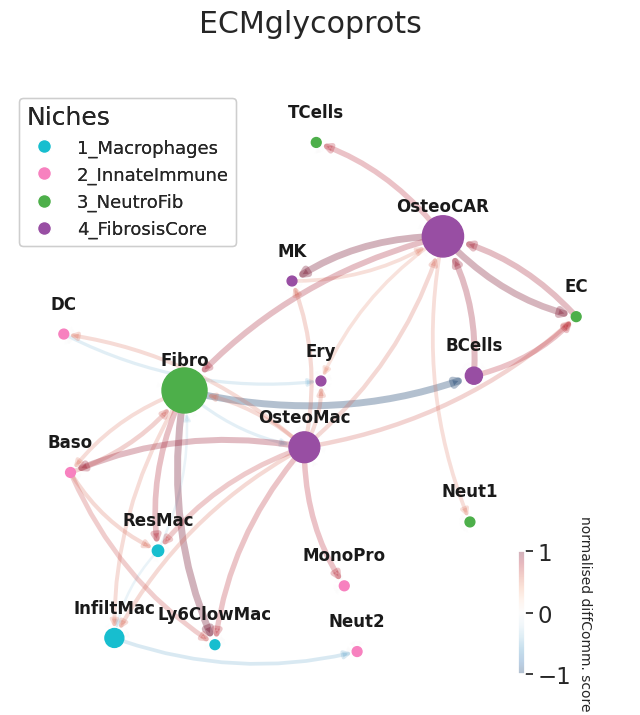

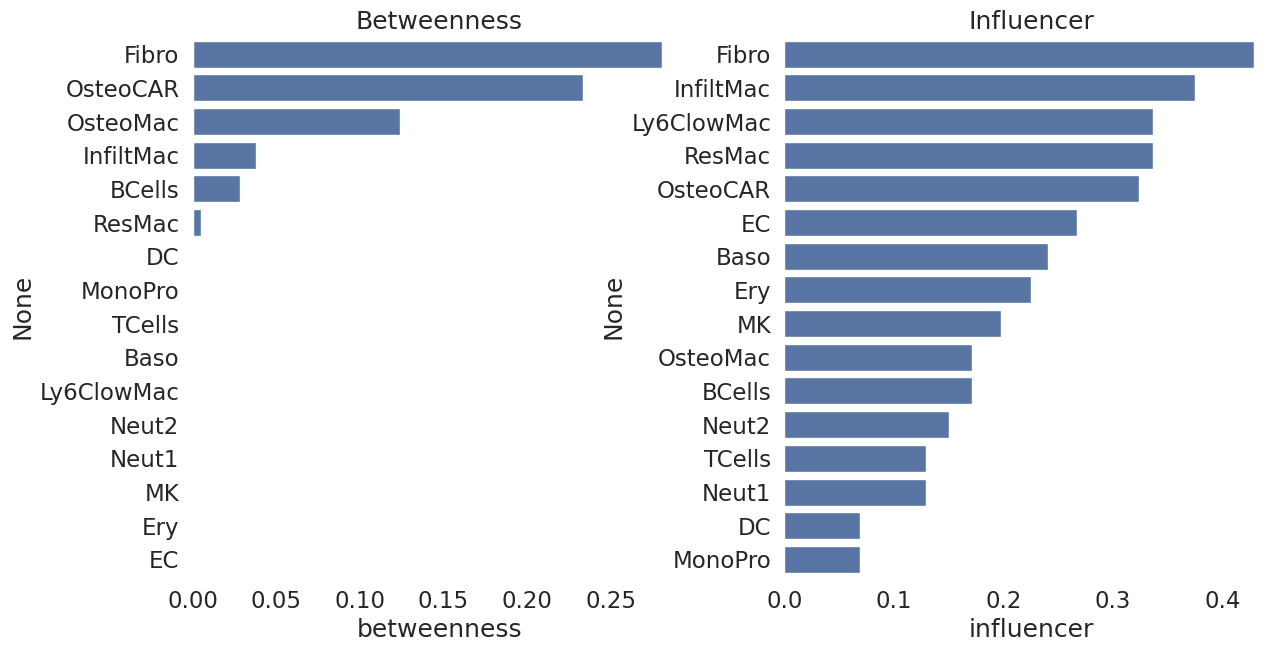

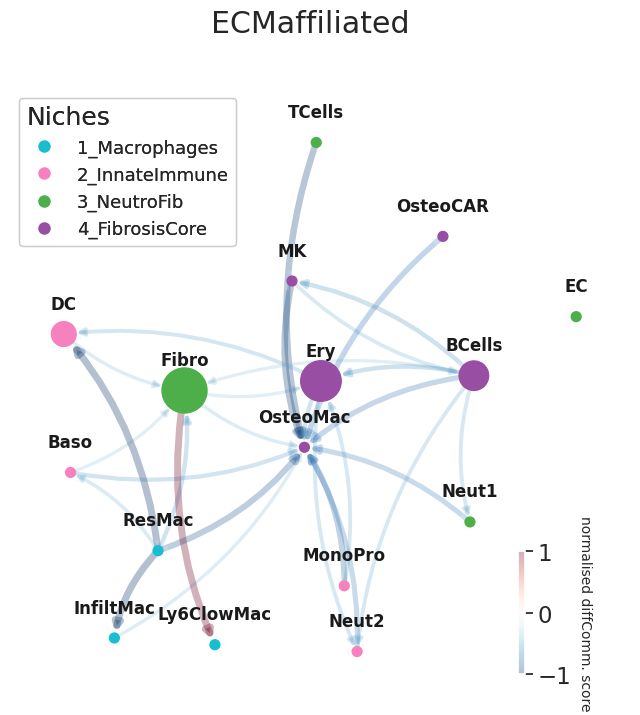

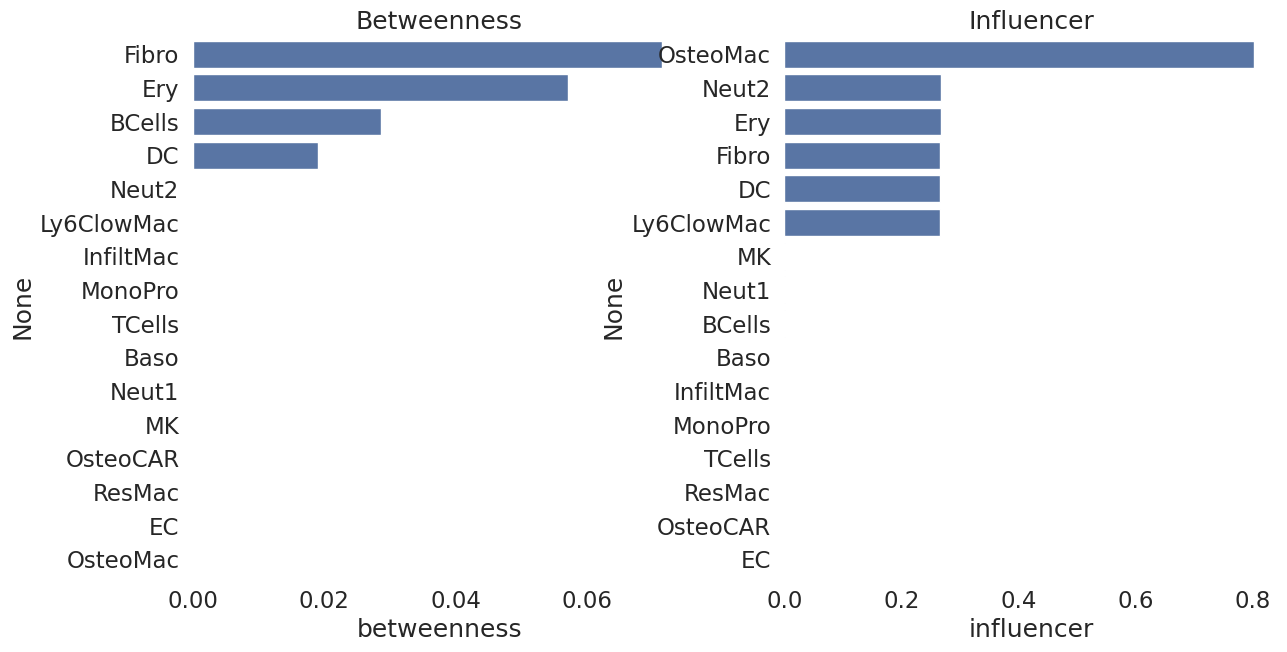

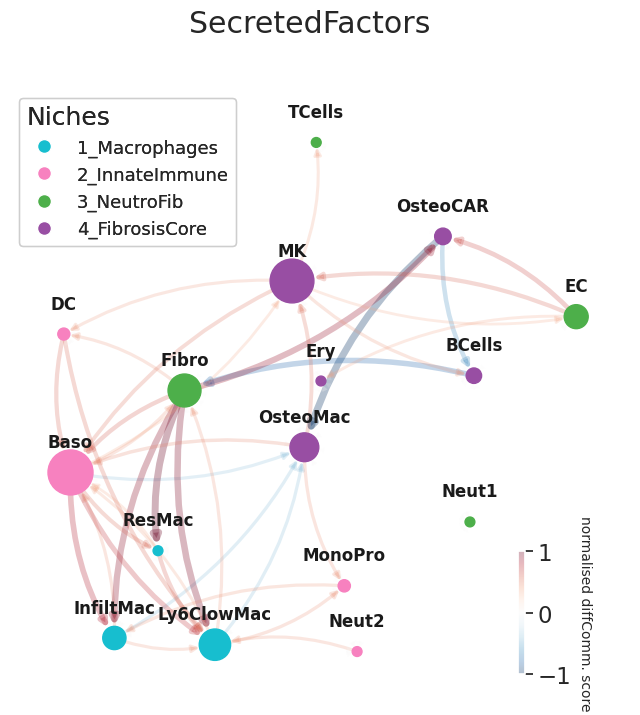

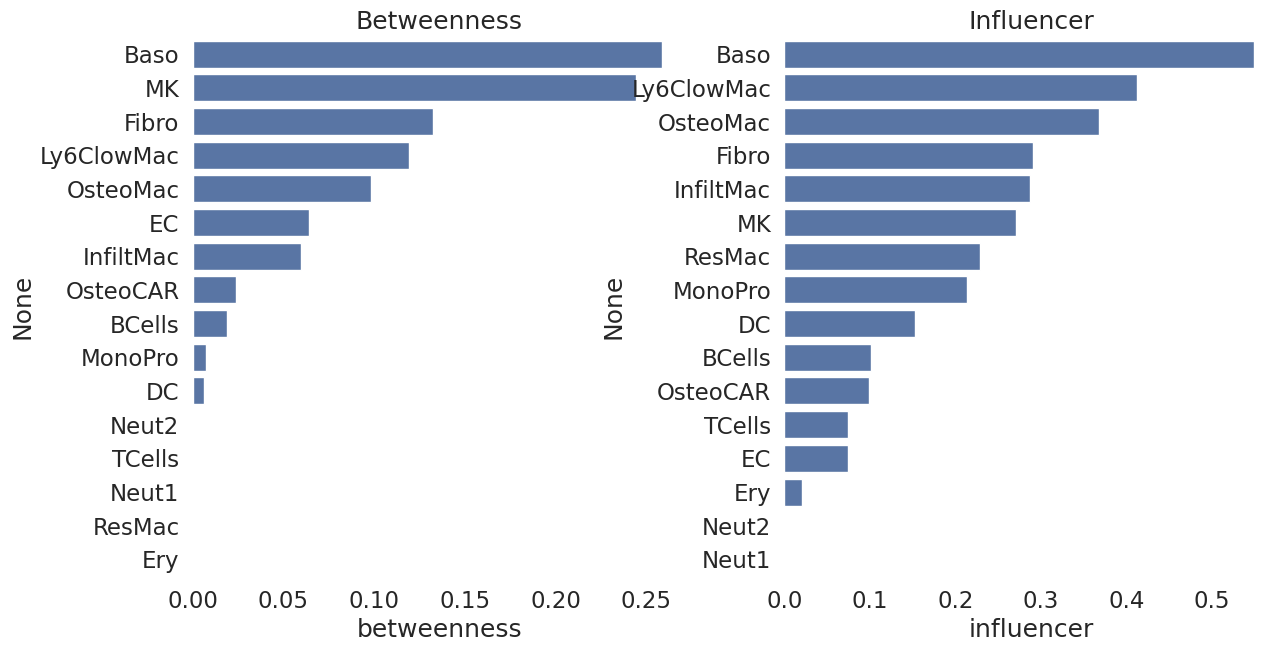

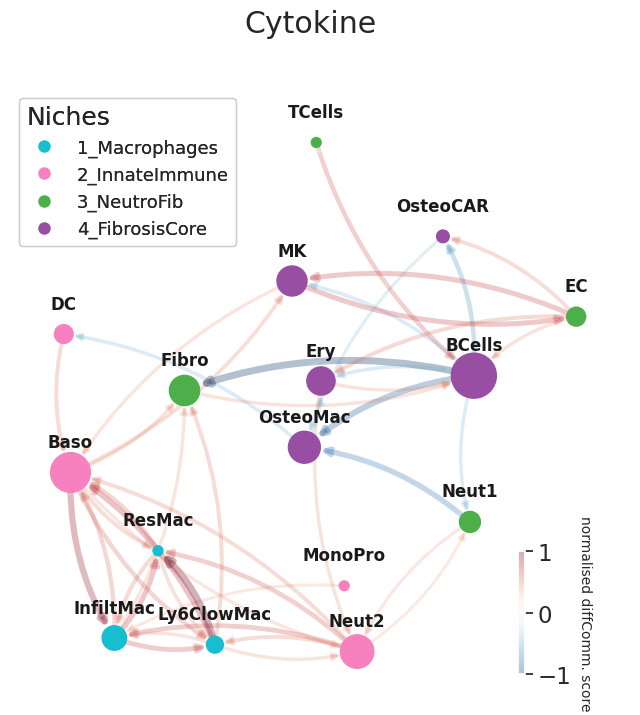

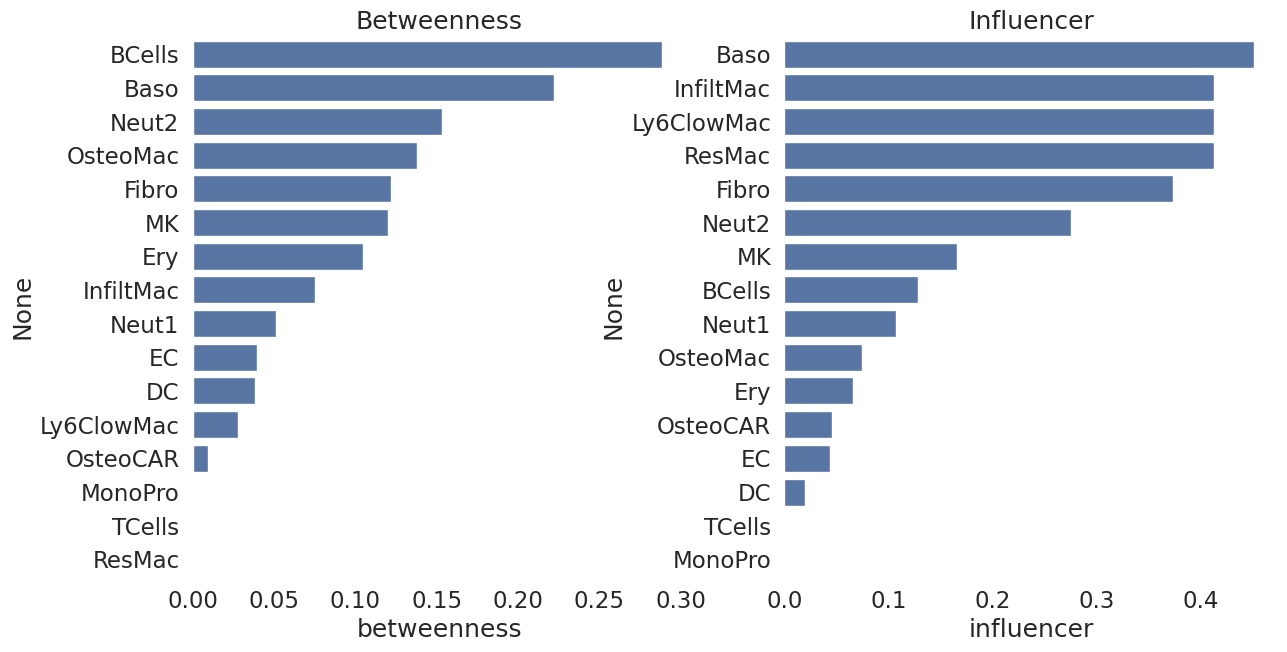

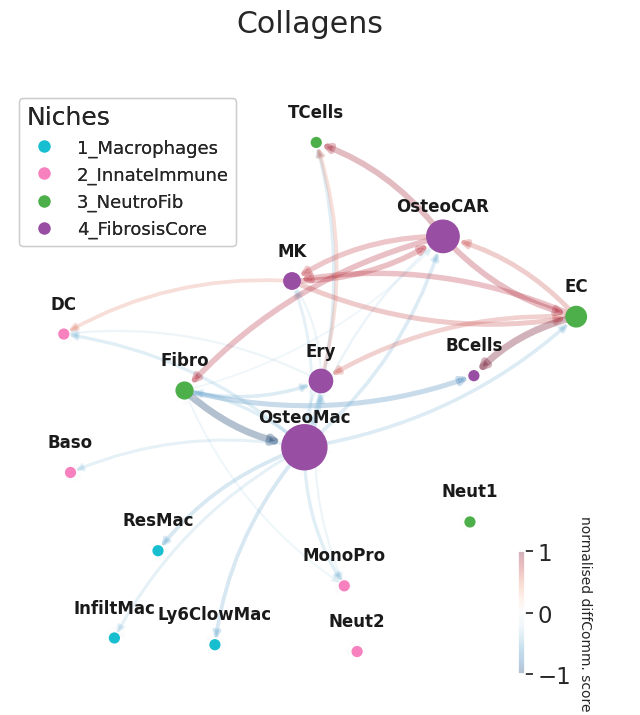

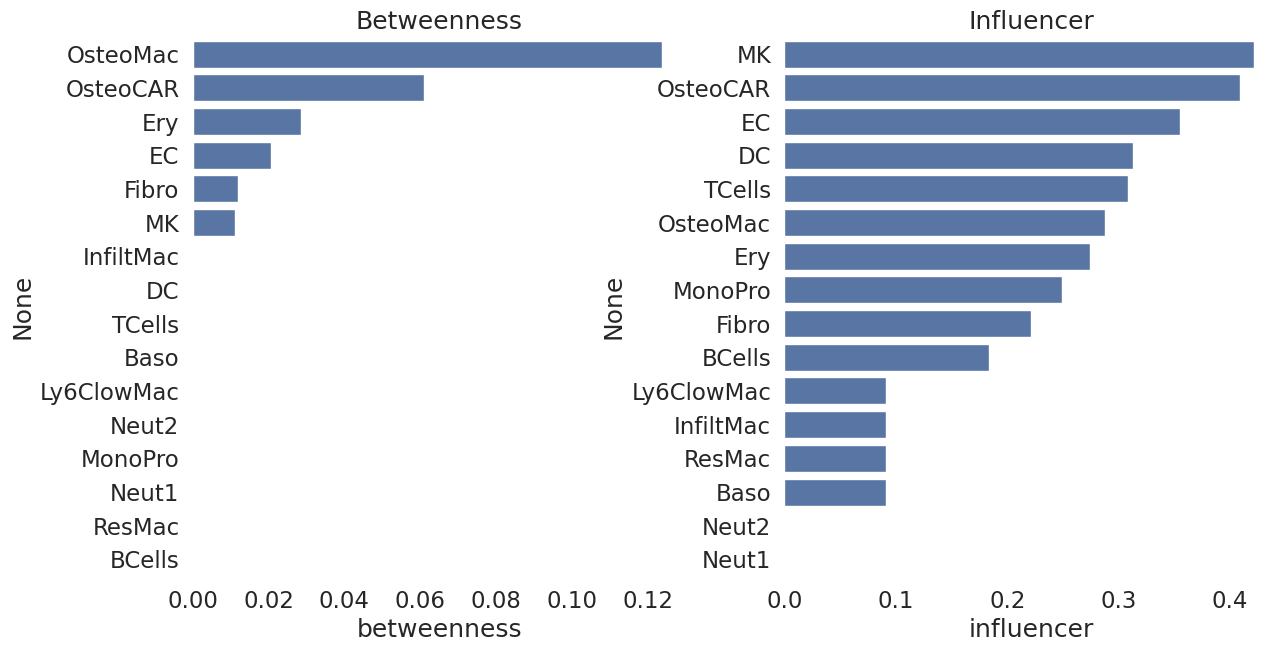

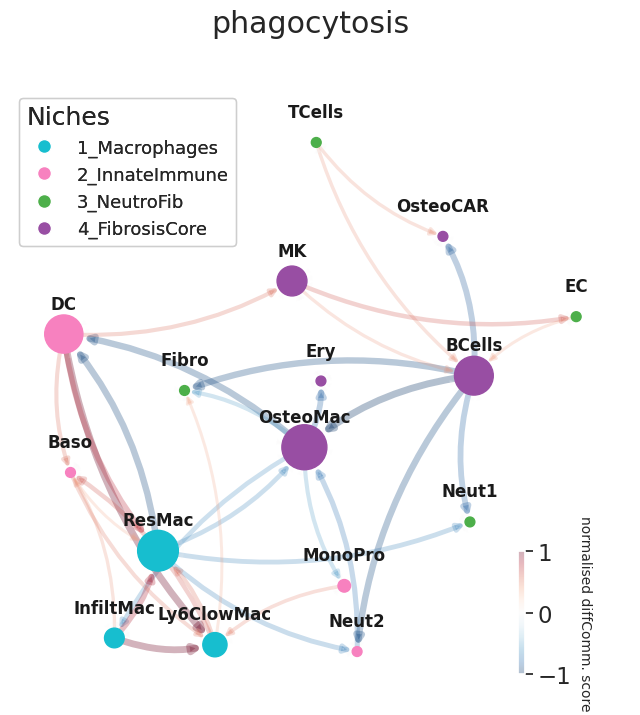

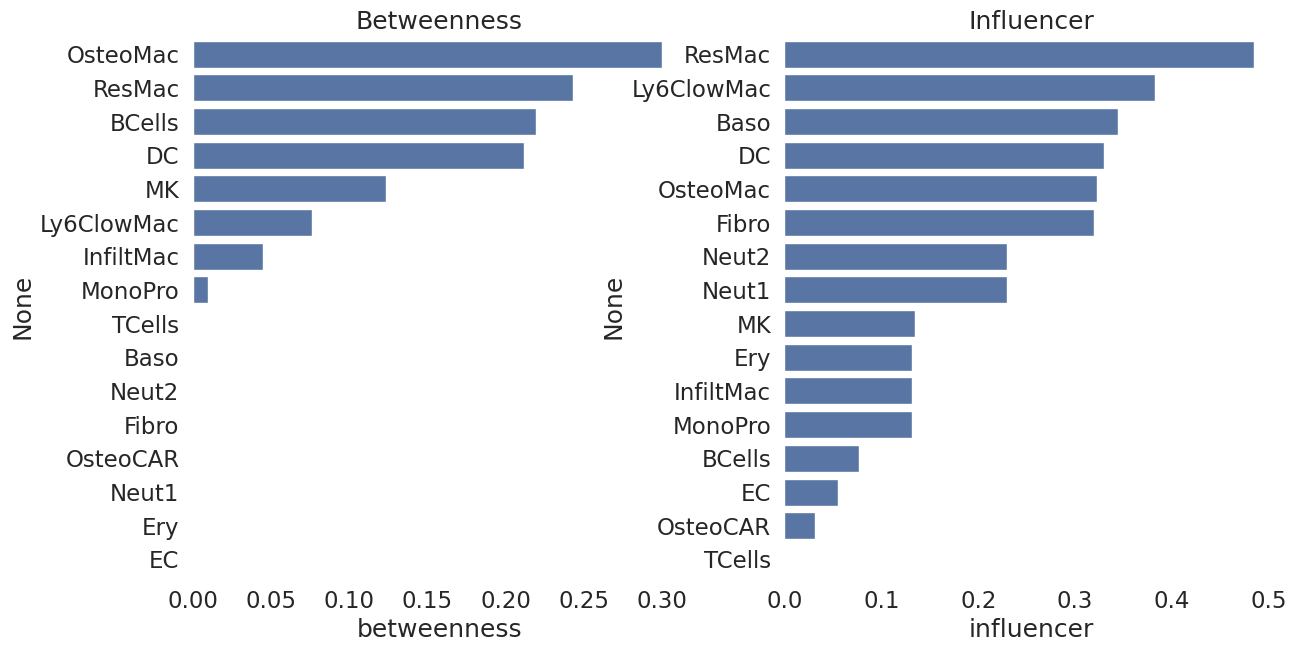

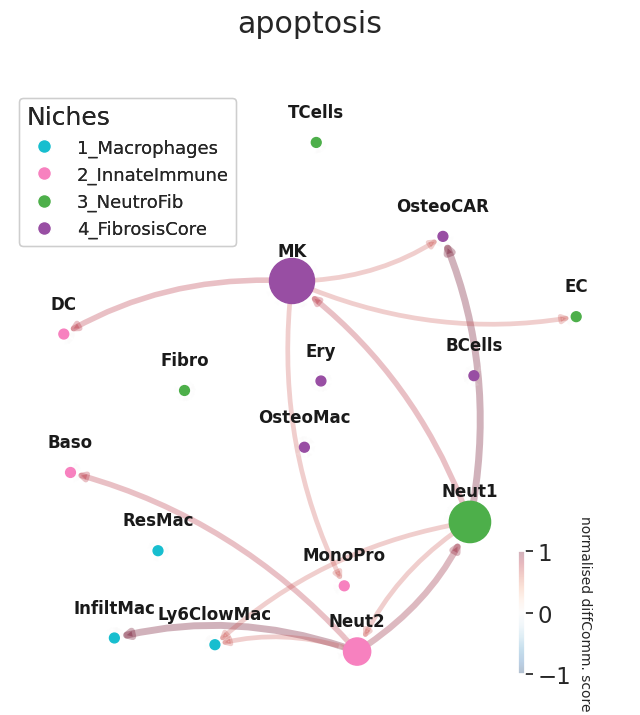

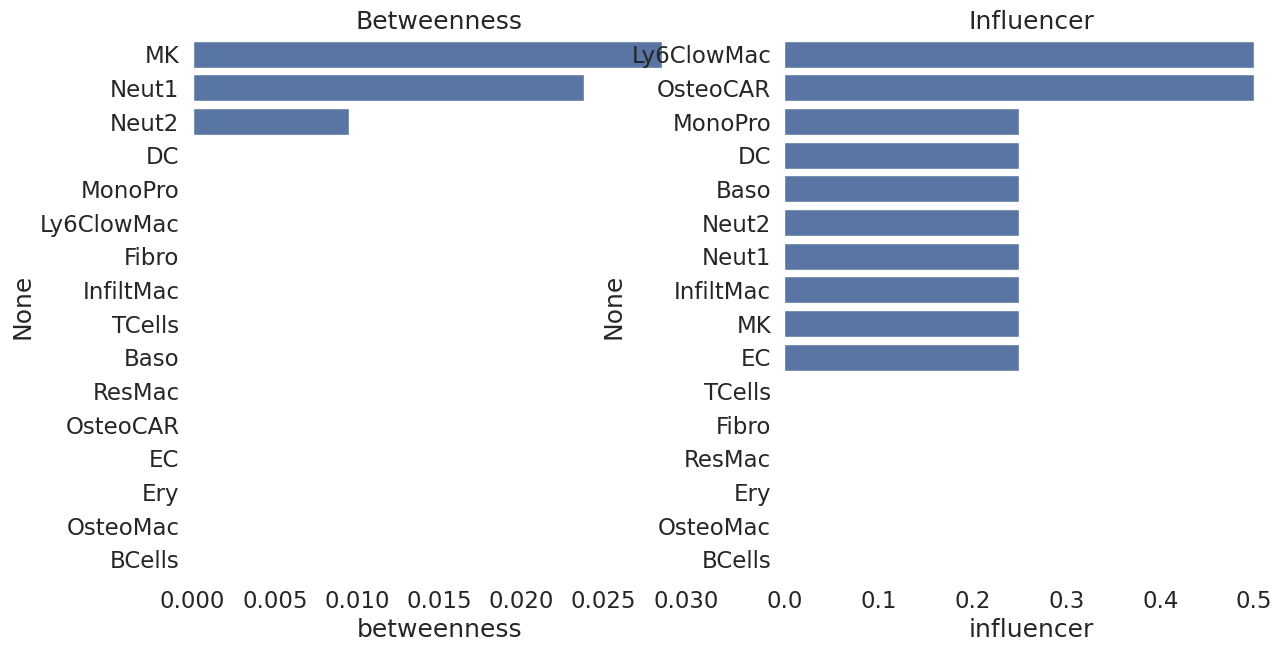

In [36]:
## Differential NWs 
plt.rcParams['axes.facecolor'] = "None"
plt.figure(frameon=False)
### Just one ligand category at a time
for cat in ['ECMglycoprots', 'ECMaffiliated', 'SecretedFactors', 'Cytokine', 'Collagens', 'phagocytosis', 'apoptosis']:
    #we will first get a matrix of differential communication scores (x_chem) from a selected ligand category and the corresponding adjacency matrix (adjChem) 
    x_chem,adjChem=nichesphere.tl.getAdj_comm(diffCommTbl=x_EVtpo_dir, pairCatDF=pairCatDFdir, ncells=16, cat=cat)
    #Then we can plot the differential communication scores of that category in a heatmap
    #And visualize these ligand-receptor interactions as edges in the colocalisation network
    plt.setp(plot.ax_heatmap.yaxis.get_majorticklabels(), rotation=1)
    G=nichesphere.tl.catNW(x_chem=x_chem,colocNW=gCol, cell_group=niches_dict, group_cmap='tab20', ncols=20, plot_title=cat, clist=clist, BTsizedNodes=True)
    legend_elements1 = [plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.tab10.colors[9], lw=4, label='1_Macrophages', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.Set1.colors[7], lw=4, label='2_InnateImmune', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.Set1.colors[2], lw=4, label='3_NeutroFib', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.Set1.colors[3], lw=4, label='4_FibrosisCore', ms=10)]

    plt.gca().add_artist(plt.legend(handles=legend_elements1,loc='upper left', fontsize=13, title='Niches', alignment='left'))
    plt.savefig('../../../figures_nichesphere_tutorial/colocFilt_commNW_'+cat+'.pdf')
    plt.show()
    
    t1=pd.DataFrame({'betweenness':[nx.betweenness_centrality(G)[x] for x in list(G.nodes)], 'influencer':[nx.eigenvector_centrality(G, max_iter=1000)[x] for x in list(G.nodes)]})
    t1.index=list(G.nodes)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    sns.barplot(ax=axes[0], y=t1.sort_values('betweenness', ascending=False).index, x='betweenness', data=t1.sort_values('betweenness', ascending=False))
    axes[0].set_title('Betweenness')
    
    sns.barplot(ax=axes[1], y=t1.sort_values('influencer', ascending=False).index, x='influencer', data=t1.sort_values('influencer', ascending=False))
    axes[1].set_title('Influencer')
    plt.savefig('../../../figures_nichesphere_tutorial/nwStats_'+cat+'.pdf')